In [1]:
import matplotlib.pyplot as plt

import numpy as np
import ROOT, uproot
#root_numpy
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import feature_selection


# import necessary keras modules/functions
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense, Dropout, MaxPooling2D
from keras.layers import BatchNormalization, Activation, AveragePooling2D, Concatenate
from keras import regularizers
from utils import PlotLearning

Welcome to JupyROOT 6.18/00


Using TensorFlow backend.


In [2]:
events = uproot.open("../FlatTree_Production/Z_Candidates_100k.root")["candidateTree"]
events.keys()

['nRecLep',
 'recLepPt1',
 'recLepEta1',
 'recLepPhi1',
 'recLepIsoVar1',
 'recLepCharge1',
 'recLepPDGID1',
 'recLepPt2',
 'recLepEta2',
 'recLepPhi2',
 'recLepIsoVar2',
 'recLepCharge2',
 'recLepPDGID2',
 'recLepInvMass',
 'genLepInvMass']

In [3]:
data = events.arrays(events.keys())

array = []
for i in events.keys():
    array.append(events.array(i))

array = np.array(array)

In [4]:
data = array.T
nBins=20
kappa=8
nvar=14
massMin=50
massMax=130
Z_mass=91.1876
epochs=50;
#[list(i) for i in root_numpy.tree2array(outTree, start=0, stop = n_events)]

binwidth = ((massMax-massMin)/nBins)
bins = np.array(range(massMin, massMax+binwidth, binwidth))
#print(bins)
x = np.array([i[:-1] for i in data])
xNew = []
y = np.array([i[-1] for i in data])
yNew = []
for i in range(len(y)): 
    migVec = np.searchsorted(bins, y[i]) - np.searchsorted(bins, x[i][-1])
    if abs(migVec)<2 : 
        xNew.append(x[i])
        yNew.append(migVec)

xNew = np.array(xNew)
print(xNew.shape)
xNew = feature_selection.SelectKBest(k=12).fit_transform(xNew, yNew)    
print(xNew.shape)

a = yNew.count(0)
print(len(yNew))
print(float((yNew.count(0))) / float(len(yNew))*100)
ycat = keras.utils.to_categorical(yNew, np.amax(yNew)-np.amin(yNew)+1)
xNew = preprocessing.scale(xNew)
x_train, x_test, y_train, y_test = train_test_split(xNew, ycat, test_size=0.2, random_state=42)

#print(x_train.shape)

#x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
#x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
#print(ycat)[:20]

(19699, 14)
(19699, 12)
19699
62.1452865628
('x_train shape:', (15759, 12))
(15759, 'train samples')
(3940, 'test samples')


In [5]:
model = Sequential()
#,input_shape=(64, nvar)
model.add(Dense(300, input_dim=xNew.shape[1], kernel_initializer = 'normal', activation='linear'))
#model.add(Flatten())
model.add(Dense(800,activation='sigmoid'))
#model.add(Dropout(0.2, seed=42))
#model.add(Dense(800,activation='exponential'))
model.add(Dense(500,activation='sigmoid'))
    #,kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01))
    # model.add(Dropout(0.25))
    # model.add(Dense(2*NBins,activation='relu'))
    # model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))
model.summary()
model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

W0808 11:29:10.265372 139989198526272 deprecation_wrapper.py:119] From /home/aidanwiederhold/.local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0808 11:29:10.276720 139989198526272 deprecation_wrapper.py:119] From /home/aidanwiederhold/.local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0808 11:29:10.279258 139989198526272 deprecation_wrapper.py:119] From /home/aidanwiederhold/.local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0808 11:29:10.291268 139989198526272 deprecation_wrapper.py:119] From /home/aidanwiederhold/.local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 300)               3900      
_________________________________________________________________
dense_2 (Dense)              (None, 800)               240800    
_________________________________________________________________
dense_3 (Dense)              (None, 500)               400500    
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 1503      
Total params: 646,703
Trainable params: 646,703
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Define additional callbacks

def reduce_lr(patience_lr):
    reduce_lr_loss = keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=patience_lr, verbose=1, min_delta=1e-4, mode='auto')
    return reduce_lr_loss

callbacks = [reduce_lr(patience_lr=20), PlotLearning()]

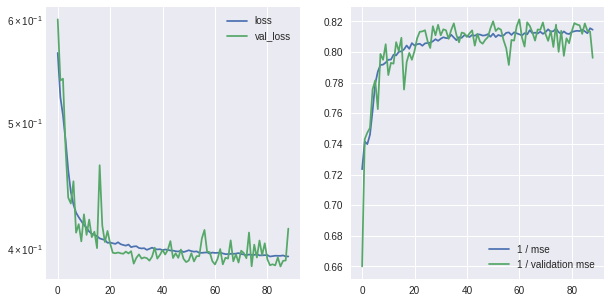

Epoch 90/200
 5376/15759 [=========>....................] - ETA: 1s - loss: 0.3884 - acc: 0.8178

In [ ]:
history = model.fit(x_train, y_train, epochs=200, batch_size=64,  verbose=1, validation_data=(x_test, y_test), callbacks = callbacks)